In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/ImageSegmentation/custom_dataset_human_black_background")

In [ ]:
import cv2, os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# from tensorflow.keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.inception_v3 import InceptionV3

import numpy as np

import matplotlib.pyplot as plt

import cv2

import random

from sklearn.model_selection import train_test_split

from google.colab.patches import cv2_imshow

In [ ]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
epochs = 50
batch_size = 16
ImgDir = "/content/drive/MyDrive/ImageSegmentation/custom_dataset_human_black_background/"

In [ ]:
features = os.listdir(f"{ImgDir}features/")
labels = os.listdir(f"{ImgDir}labels/")

print(len(features), len(labels))

4731 4731


In [ ]:
X = features
y = labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.15, random_state=1)

print(len(X_train), len(X_val), len(X_test))

3311 1207 213


In [ ]:
def keras_generator_train_val_test(batch_size, choice="train"):

    if choice == "train":
        X = X_train
        y = y_train
    elif choice == "val":
        X = X_val
        y = y_val
    elif choice == "test":
        X = X_test
        y = y_test
    else:
        print("Invalid Option")
        return False
        
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            x_rand = random.choice(X)
            y_rand = x_rand[:-5]+"y.jpg"
            
            x_path = f"{ImgDir}features/{x_rand}"
            y_path = f"{ImgDir}labels/{y_rand}"

            x = cv2.imread(x_path)
            y = cv2.imread(y_path)

            x = x / 255.
            y = y / 255.
            
            x_batch.append(x)
            y_batch.append(y)

        
        x_batch = np.array(x_batch)
        # y_batch = np.array(y_batch)

        y_batch = {'seg': np.array(y_batch),
                #    'cls': np.array(classification_list)
                }

        yield x_batch, y_batch

for x, y in keras_generator_train_val_test(2, choice="train"):
    break

print(x.shape, y['seg'].shape)

(2, 512, 512, 3) (2, 512, 512, 3)


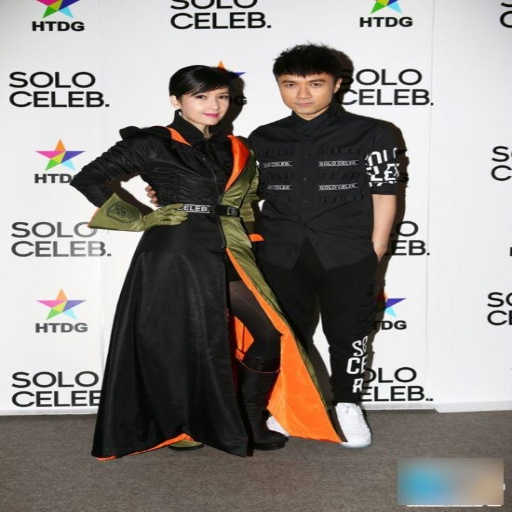

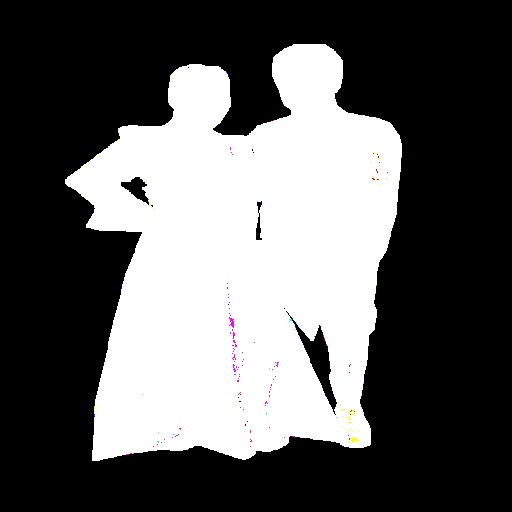

In [ ]:
cv2_imshow(x[0] * 255.)
cv2_imshow(y['seg'][0] * 255.)

In [ ]:
def get_model():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    losses = {'seg': 'binary_crossentropy'
            }

    metrics = {'seg': ['acc']
                }
    model.compile(optimizer="adam", loss = losses, metrics=metrics)

    return model

In [ ]:
import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, epoch, logs={}):

        res_dir = "intermediate_results_black_background"

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

        print('Training: epoch {} begins at {}'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self, epoch, logs=None):
        res_dir = "intermediate_results_black_background/"
        print('Training: epoch {} ends at {}'.format(epoch, datetime.datetime.now().time()))
        
        for x_test, y_test in keras_generator_train_val_test(batch_size, choice="test"):
            break
        p = np.reshape(x_test[0], (1, 512, 512, 3))
        prediction = self.model.predict(p)

        x_img = f"{res_dir}{epoch}_X_input.jpg"
        y_img = f"{res_dir}{epoch}_Y_truth.jpg"
        predicted_img = f"{res_dir}{epoch}_Y_predicted.jpg"

        cv2.imwrite(x_img, x_test[0] * 255.)
        cv2.imwrite(y_img, y_test['seg'][0] * 255.)
        cv2.imwrite(predicted_img, prediction[0] * 255.)